In [7]:
import math

import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt
import torch
import pandas as pd
from torch import nn

from pandas_datareader import data as pdr

yf.pdr_override()
SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
START = dt.datetime(2022, 1, 31)
END = dt.datetime(2022, 11, 20)


def fetch_stocks(symbols):
    prices = pdr.get_data_yahoo(symbols, START, END)
    for symbol in symbols:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df.to_csv(f"data/{symbol}.csv")


def load_dataset():
    all_stocks_data = []
    for symbol in SPY_TOP_10_SYMBOLS:
        _data = pd.read_csv(f"./data/{symbol}.csv")
        _data.index = pd.to_datetime(_data["Date"])
        _data["Symbol"] = symbol
        _data["Close"] /= _data["Close"][0]
        all_stocks_data.append(_data.drop("Date", axis=1))
        break

    combined = pd.concat(all_stocks_data)
    combined["Symbol"] = combined["Symbol"].astype("category").cat.codes

    return combined


SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]

def format_dataset():
    prices = pdr.get_data_yahoo(SYMBOLS, START, END)
    all_stocks_data = []

    for symbol in SYMBOLS:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df["symbol"] = symbol
        stock_df["date"] = pd.to_datetime(stock_df.index)
        stock_df["price"] = stock_df["Adj Close"]
        all_stocks_data.append(stock_df[["symbol", "date", "price"]].reset_index(drop=True))

    combined = pd.concat(all_stocks_data)
    combined.to_csv("data.csv")

format_dataset()

[*********************100%***********************]  10 of 10 completed


In [42]:
data = load_dataset()
test_cutoff = dt.datetime(2022, 9, 30)
validation_cutoff = END

training_data = data[data.index <= test_cutoff]
validation_data = data[test_cutoff < data.index]

training_padding = np.zeros(16 - (len(training_data) - 1) % 16)
validation_padding = np.zeros(16 - (len(validation_data) - 1) % 16)

x_train = torch.from_numpy(np.concatenate([training_data["Close"][:-1].to_numpy(), training_padding]))
y_train = torch.from_numpy(np.concatenate([training_data["Close"][1:].to_numpy(), training_padding]))

x_test = torch.from_numpy(np.concatenate([validation_data["Close"][:-1].to_numpy(), validation_padding]))
y_test = torch.from_numpy(np.concatenate([validation_data["Close"][1:].to_numpy(), validation_padding]))

In [43]:
from torch.utils.data import DataLoader

x_train_dataloader = DataLoader(x_train, batch_size=16)
x_test_dataloader = DataLoader(x_test, batch_size=16)

y_train_dataloader = DataLoader(y_train, batch_size=16)
y_test_dataloader = DataLoader(y_test, batch_size=16)

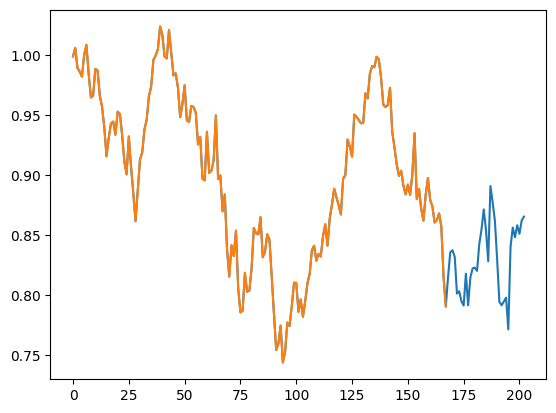

In [64]:
[plt.plot(d["Close"]) for _, d in data[1:].reset_index(drop=True).groupby("Symbol")]
plt.plot(y_train[:-8])
plt.show()

In [31]:
class PositionalEncoding(nn.Module):
    def __init__(self, dims, length = 5000):
        super().__init__()

        encodings = torch.zeros(length, dims)
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        divisor = torch.exp(torch.arange(0, dims, 2).float() * (-math.log(10000.0) / dims))

        encodings[:, 0::2] = torch.sin(position * divisor)
        encodings[:, 1::2] = torch.cos(position * divisor)
        self.register_buffer("encodings", encodings.unsqueeze(0).transpose(0, 1))

    def forward(self, x):
        return x + self.encodings[:x.size(0), :]

In [32]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, features = 128, dropout = 0.2):
        super().__init__()

        self.pos_encoder = PositionalEncoding(features)
        encoderLayer = nn.TransformerEncoderLayer(d_model=features, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoderLayer, 1)
        self.transformer_decoder = nn.Linear(features, 1)

    def forward(self, inputs):
        mask = self._generate_square_subsequent_mask(len(inputs))
        source = self.pos_encoder(inputs)
        out = self.transformer_encoder(source, mask)
        return self.transformer_decoder(out)

    @staticmethod
    def _generate_square_subsequent_mask(length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

In [33]:
def train(model, x_data, y_data, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in zip(x_data, y_data):
        source, target = x.to(torch.float32), y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(source)

        loss = criterion(outputs, target) ** 0.5
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss


In [46]:
def validate(model, x_data, y_data, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in zip(x_data, y_data):
        source, target = x.to(torch.float32), y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(source)

        loss = criterion(outputs, target) ** 0.5
        total_loss += loss.item()

    return total_loss

In [47]:
model = TimeSeriesTransformer(16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
EPOCHS = 100

for epoch in range(EPOCHS + 1):
    training_loss = train(model, x_train_dataloader, y_train_dataloader, optimizer, criterion)
    validation_loss = validate(model, x_test_dataloader, y_test_dataloader, optimizer, criterion)
    scheduler.step()
    if epoch % 10 == 0:
        print(f"EPOCH: {epoch}, Training Loss: {training_loss}, Validation Loss: {validation_loss}")

EPOCH: 0, Training Loss: 6.56760348379612, Validation Loss: 1.1926582157611847


C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH: 10, Training Loss: 1.5753103010356426, Validation Loss: 0.9761101305484772
EPOCH: 20, Training Loss: 1.472699224948883, Validation Loss: 1.0007415264844894
EPOCH: 30, Training Loss: 1.3826587311923504, Validation Loss: 0.9676166921854019
EPOCH: 40, Training Loss: 1.285889282822609, Validation Loss: 0.9217548370361328
EPOCH: 50, Training Loss: 1.2685366161167622, Validation Loss: 0.9477934390306473
EPOCH: 60, Training Loss: 1.236301340162754, Validation Loss: 0.9594924598932266
EPOCH: 70, Training Loss: 1.3401177376508713, Validation Loss: 0.9245171472430229
EPOCH: 80, Training Loss: 1.2025604099035263, Validation Loss: 0.8973971009254456
EPOCH: 90, Training Loss: 1.1986522264778614, Validation Loss: 0.9353199303150177
EPOCH: 100, Training Loss: 1.2556087002158165, Validation Loss: 0.917217068374157


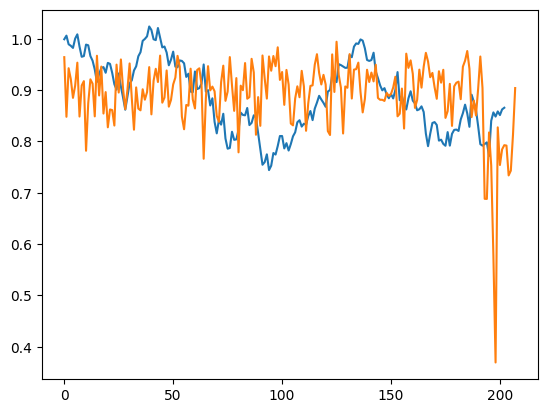

In [63]:
data_padding = np.zeros(16 - (len(data)) % 16)

dataloader = DataLoader(torch.from_numpy(np.concatenate([data["Close"].to_numpy(), data_padding])), batch_size=16)
predictions = []
for d in dataloader:
    predictions.append(model(d.to(torch.float32)).squeeze().detach().numpy())
# predictions = model(np.concatenate([data["Close"].to_numpy(), data_padding]))
#
[plt.plot(d["Close"]) for _, d in data[1:].reset_index(drop=True).groupby("Symbol")]
# plt.plot(y_train)
plt.plot(np.concatenate(predictions))
plt.show()